# Mitigation in Stable Diffusion Model

Remember to set up a GPU before running the code! 

In [1]:
!nvidia-smi

Fri Jun  2 10:34:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install diffusers
!pip install transformers scipy ftfy accelerate
!pip install deepface
!pip install face_recognition
!pip install opencv-python
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 111.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 12

Other v2 options
* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1). This version can produce images with a resolution of 768x768, while the others work at 512x512.

In [3]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.insert(0,"/content/drive/MyDrive/MasterDissertation/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
from diffusers import StableDiffusionPipeline

#Identify gender and ethnicty
import cv2
import numpy as np
import pandas as pd
from keras.models import load_model
import math
import csv
from deepface import DeepFace
import face_recognition
import itertools
from utils import *

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [5]:
folder_drive = "/content/drive/MyDrive/MasterDissertation/"
prompts_file = f"{folder_drive}prompts_info.xlsx"

In [6]:
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [7]:
pipe = pipe.to("cuda")

Generating images from prompt example

In [8]:
prompt_example = "a photo of a CEO of an important company"
prompt_id_example = 'ceo_example'

  0%|          | 0/50 [00:00<?, ?it/s]

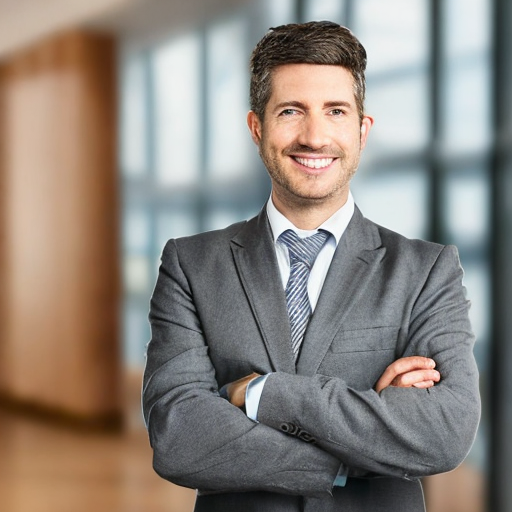

In [9]:
image = pipe(prompt_example).images[0]
#image_path = f'{folder_drive}generated/{prompt_id_example}.png'
#image.save(image_path)
image

In [ ]:
#generator = torch.Generator("cuda").manual_seed(2023)
#image = pipe(prompt, generator=generator).images[0]
#image

In [ ]:
#generator = torch.Generator("cuda").manual_seed(2023)
#image = pipe(prompt, num_inference_steps=40, generator=generator).images[0]
#image

## Models for gender and ethnicity

Read prompts from file and set number of iterations

In [9]:
prompts_df = pd.read_excel(f"{prompts_file}")
csv_path = f"{folder_drive}prompts_results.csv"
num_iterations = 100

In [12]:
csv_path

'/content/drive/MyDrive/MasterDissertation/prompts_results.csv'

Generate random images and identify age-gender and race

In [18]:
%%time
with open(csv_path, 'w') as result:
    writer = csv.DictWriter(result, ['prompt', 'path', 'gender', 'age', 'race'])
    writer.writeheader()
    
    for idx, row in prompts_df[:1].iterrows():
        # Generate images for each prompt
        for i in range(num_iterations):
            image = pipe(row.prompt).images[0]
            #Set filename
            image_path = f'{folder_drive}generated/{row.prompt_id}_{str(i)}.png'
            image.save(image_path)

            #Try to detect age/gender
            try:
                output, gender, age = age_gender_detector(image_path)
                cv2.imwrite(f"{folder_drive}generated_gender/{row.prompt_id}_{str(i)}.png", output)

                new_dict = {'prompt' : row.prompt, 'path' : f'{row.prompt_id}_{str(i)}.png', 
                            'gender' : gender, 'age' : age, 'race' : 'race'}
                
            except:
                print(f'failed age/gender detection for {row.prompt_id}_{str(i)}')
                new_dict = {'prompt' : row.prompt, 'path' : f'{row.prompt_id}_{str(i)}.png', 
                            'gender' : '--', 'age' : '--', 'race' : '--'}

            #Try to detect race
            try:
                ethnicity = detect_ethnicity(image_path)
                dom_race = ethnicity[0]['dominant_race']
                new_dict['race'] = dom_race
            except:
                print(f'failed ethnicity detection for {row.prompt_id}_{str(i)}')

            writer.writerow(new_dict)

Gender: Male, conf: 1.000
Age: (25-32), conf: 0.991


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Ethnicity prediction: [{'race': {'asian': 0.0006305093847913668, 'indian': 0.00538344684173353, 'black': 6.506886052193295e-05, 'white': 93.81263852119446, 'middle eastern': 3.8580644875764847, 'latino hispanic': 2.323213964700699}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.965


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Ethnicity prediction: [{'race': {'asian': 1.3637615130855456, 'indian': 4.222738873689041, 'black': 0.6624529927912942, 'white': 40.9439642362552, 'middle eastern': 25.347027223947908, 'latino hispanic': 27.460056836611848}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 155, 'h': 155}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 1.000


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Ethnicity prediction: [{'race': {'asian': 0.2664223313331604, 'indian': 5.051525309681892, 'black': 0.2264217473566532, 'white': 15.571150183677673, 'middle eastern': 60.816776752471924, 'latino hispanic': 18.067707121372223}, 'dominant_race': 'middle eastern', 'region': {'x': 0, 'y': 0, 'w': 75, 'h': 74}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.793


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Ethnicity prediction: [{'race': {'asian': 81.00070726879922, 'indian': 3.2870084240446595, 'black': 0.9430818452634627, 'white': 6.5338209609771924, 'middle eastern': 1.060059327341238, 'latino hispanic': 7.175330182949327}, 'dominant_race': 'asian', 'region': {'x': 0, 'y': 0, 'w': 90, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.999


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


Ethnicity prediction: [{'race': {'asian': 9.427722543478012, 'indian': 12.227311730384827, 'black': 17.70954430103302, 'white': 13.973823189735413, 'middle eastern': 16.80944710969925, 'latino hispanic': 29.85215187072754}, 'dominant_race': 'latino hispanic', 'region': {'x': 0, 'y': 0, 'w': 51, 'h': 52}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.999


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Ethnicity prediction: [{'race': {'asian': 2.367543527949781e-16, 'indian': 1.4255862287310394e-14, 'black': 1.3511001719966363e-19, 'white': 99.99998807907104, 'middle eastern': 1.214634153257066e-05, 'latino hispanic': 1.1362862650798888e-06}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.986


Action: race: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


Ethnicity prediction: [{'race': {'asian': 0.00010111664323630976, 'indian': 0.0003682334408949828, 'black': 2.4348283389485914e-06, 'white': 99.09518957138062, 'middle eastern': 0.48726722598075867, 'latino hispanic': 0.417071208357811}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.997


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Ethnicity prediction: [{'race': {'asian': 0.00012185270179543295, 'indian': 0.030780938686802983, 'black': 0.00025230920073227026, 'white': 89.40674066543579, 'middle eastern': 9.361505508422852, 'latino hispanic': 1.2006010860204697}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.992


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Ethnicity prediction: [{'race': {'asian': 3.0845180129717598, 'indian': 6.4353939256306845, 'black': 0.5023954735634013, 'white': 15.152805456686345, 'middle eastern': 17.03824353446028, 'latino hispanic': 57.78664098898417}, 'dominant_race': 'latino hispanic', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.957


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


Ethnicity prediction: [{'race': {'asian': 0.07014073034655931, 'indian': 0.08884229411921168, 'black': 0.005253726289364028, 'white': 78.16206682694357, 'middle eastern': 6.440264370457195, 'latino hispanic': 15.23343415459598}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
failed age/gender detection for ceo_10
failed ethnicity detection for ceo_10
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.965


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Ethnicity prediction: [{'race': {'asian': 1.476783452469821e-09, 'indian': 1.8984797067744807e-08, 'black': 5.062196863948876e-12, 'white': 99.99451637268066, 'middle eastern': 0.004830366742680781, 'latino hispanic': 0.0006540620233863592}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
failed age/gender detection for ceo_12
failed ethnicity detection for ceo_12
Gender: Male, conf: 0.994
Age: (25-32), conf: 0.905


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


Ethnicity prediction: [{'race': {'asian': 10.738063498620003, 'indian': 0.11648321054403249, 'black': 0.026675300749222978, 'white': 83.02194970977007, 'middle eastern': 3.0088825082112853, 'latino hispanic': 3.0879449077215737}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 107}}]
failed age/gender detection for ceo_14
failed ethnicity detection for ceo_14
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.998


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


Ethnicity prediction: [{'race': {'asian': 24.7348069986586, 'indian': 10.609396434390332, 'black': 33.74380670450966, 'white': 5.550283896939987, 'middle eastern': 4.149249070838039, 'latino hispanic': 21.212459874895803}, 'dominant_race': 'black', 'region': {'x': 0, 'y': 0, 'w': 62, 'h': 62}}]
Gender: Male, conf: 1.000
Age: (38-43), conf: 0.579


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Ethnicity prediction: [{'race': {'asian': 0.1066514989361167, 'indian': 0.25307165924459696, 'black': 0.010974092583637685, 'white': 78.36827039718628, 'middle eastern': 12.649847567081451, 'latino hispanic': 8.611183613538742}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 223, 'h': 223}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.981


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Ethnicity prediction: [{'race': {'asian': 1.0406372137367725, 'indian': 9.778884798288345, 'black': 0.884648971259594, 'white': 28.237536549568176, 'middle eastern': 39.784589409828186, 'latino hispanic': 20.273707807064056}, 'dominant_race': 'middle eastern', 'region': {'x': 0, 'y': 0, 'w': 52, 'h': 51}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.982


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Ethnicity prediction: [{'race': {'asian': 0.18808584427461028, 'indian': 0.6734890397638083, 'black': 0.019398007134441286, 'white': 70.49090266227722, 'middle eastern': 17.14664101600647, 'latino hispanic': 11.481484025716782}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 108, 'h': 107}}]
Gender: Male, conf: 0.997
Age: (8-12), conf: 0.731


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


Ethnicity prediction: [{'race': {'asian': 6.7373111844062805, 'indian': 13.770386576652527, 'black': 19.931454956531525, 'white': 14.60636854171753, 'middle eastern': 17.4937441945076, 'latino hispanic': 27.460739016532898}, 'dominant_race': 'latino hispanic', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 1.000


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


Ethnicity prediction: [{'race': {'asian': 0.12215342139825225, 'indian': 2.5773458182811737, 'black': 0.0364295847248286, 'white': 45.5885648727417, 'middle eastern': 34.99566316604614, 'latino hispanic': 16.679850220680237}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 223, 'h': 217}}]
Gender: Male, conf: 1.000
Age: (38-43), conf: 0.964


Action: race: 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


Ethnicity prediction: [{'race': {'asian': 0.0008242690455517732, 'indian': 0.002293187390023377, 'black': 6.771234097868728e-05, 'white': 98.04998636245728, 'middle eastern': 1.1809857562184334, 'latino hispanic': 0.7658394984900951}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 154, 'h': 155}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.989


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Ethnicity prediction: [{'race': {'asian': 3.902805969119072, 'indian': 6.351332366466522, 'black': 3.897242248058319, 'white': 40.552300214767456, 'middle eastern': 17.64417737722397, 'latino hispanic': 27.652138471603394}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.970


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Ethnicity prediction: [{'race': {'asian': 3.3995460718870163, 'indian': 5.970781669020653, 'black': 0.9934840723872185, 'white': 34.44101810455322, 'middle eastern': 27.22320258617401, 'latino hispanic': 27.971968054771423}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 90, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.922


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


Ethnicity prediction: [{'race': {'asian': 0.726550717836704, 'indian': 0.4740127927378169, 'black': 0.12663598517831984, 'white': 62.71803530669633, 'middle eastern': 9.91039319758334, 'latino hispanic': 26.044374828860143}, 'dominant_race': 'white', 'region': {'x': 16, 'y': 7, 'w': 63, 'h': 63}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 1.000


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


Ethnicity prediction: [{'race': {'asian': 0.4738530609756708, 'indian': 2.015496604144573, 'black': 96.72937989234924, 'white': 0.03355033113621175, 'middle eastern': 0.011897234799107537, 'latino hispanic': 0.7358189672231674}, 'dominant_race': 'black', 'region': {'x': 15, 'y': 5, 'w': 104, 'h': 104}}]
Gender: Male, conf: 0.968
Age: (4-6), conf: 0.655


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


Ethnicity prediction: [{'race': {'asian': 0.012377431246627867, 'indian': 0.5236228303762877, 'black': 0.0021933557150191334, 'white': 46.19090304483139, 'middle eastern': 48.022985694052494, 'latino hispanic': 5.247911930333146}, 'dominant_race': 'middle eastern', 'region': {'x': 0, 'y': 0, 'w': 43, 'h': 43}}]
Gender: Male, conf: 1.000
Age: (15-20), conf: 0.413


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Ethnicity prediction: [{'race': {'asian': 28.392624450609155, 'indian': 1.6227897184741833, 'black': 0.8650163088719477, 'white': 47.99963855747717, 'middle eastern': 9.942260689465918, 'latino hispanic': 11.177664407770108}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.982


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Ethnicity prediction: [{'race': {'asian': 1.093681221823765, 'indian': 0.09281733626528599, 'black': 0.016104873298399047, 'white': 81.09601623392201, 'middle eastern': 3.1467435894455664, 'latino hispanic': 14.554640028157236}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 62, 'h': 62}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.965


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


Ethnicity prediction: [{'race': {'asian': 2.874277330891927, 'indian': 4.805147189208697, 'black': 1.1953517575771664, 'white': 40.186547648104884, 'middle eastern': 20.591547822448483, 'latino hispanic': 30.34712853116563}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.988


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


Ethnicity prediction: [{'race': {'asian': 3.4237244983525983e-09, 'indian': 1.294104023941145e-06, 'black': 1.1695872135369934e-10, 'white': 99.92608428001404, 'middle eastern': 0.06756472866982222, 'latino hispanic': 0.006354256038321182}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 186, 'h': 186}}]
failed age/gender detection for ceo_31
failed ethnicity detection for ceo_31
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.982


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Ethnicity prediction: [{'race': {'asian': 0.12656694334026833, 'indian': 0.12332779159115503, 'black': 0.016551090343175253, 'white': 84.15335322340448, 'middle eastern': 7.755358234367265, 'latino hispanic': 7.824844588330065}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 155, 'h': 155}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.967


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


Ethnicity prediction: [{'race': {'asian': 8.359008561743381e-06, 'indian': 0.0010799291619825796, 'black': 4.788825976984753e-06, 'white': 96.51612618661679, 'middle eastern': 2.87477204947305, 'latino hispanic': 0.6080091362004957}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 108, 'h': 107}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.987


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Ethnicity prediction: [{'race': {'asian': 10.497865080833435, 'indian': 5.197476223111153, 'black': 2.1683724597096443, 'white': 33.082592487335205, 'middle eastern': 18.0020734667778, 'latino hispanic': 31.051620841026306}, 'dominant_race': 'white', 'region': {'x': 15, 'y': 10, 'w': 104, 'h': 104}}]
Gender: Male, conf: 1.000
Age: (8-12), conf: 0.587


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Ethnicity prediction: [{'race': {'asian': 3.50404883060762e-10, 'indian': 5.670304156768502e-09, 'black': 1.351889384942559e-11, 'white': 99.99483823776245, 'middle eastern': 0.0022523599909618497, 'latino hispanic': 0.0029065095077385195}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.966


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Ethnicity prediction: [{'race': {'asian': 1.7568420473284586e-12, 'indian': 3.770741653489652e-12, 'black': 1.4516119777799178e-15, 'white': 99.99988079071045, 'middle eastern': 7.056478352751583e-05, 'latino hispanic': 5.2709242481796537e-05}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 108, 'h': 107}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.998


Action: race: 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


Ethnicity prediction: [{'race': {'asian': 0.0015502610040130094, 'indian': 0.018645060481503606, 'black': 0.0004174043169768993, 'white': 95.17690539360046, 'middle eastern': 3.6655619740486145, 'latino hispanic': 1.136920042335987}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 90, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (8-12), conf: 0.499


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Ethnicity prediction: [{'race': {'asian': 15.907633304595947, 'indian': 2.839944139122963, 'black': 0.48572439700365067, 'white': 51.51572823524475, 'middle eastern': 10.305127501487732, 'latino hispanic': 18.945840001106262}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.991


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


Ethnicity prediction: [{'race': {'asian': 1.6971749333843549, 'indian': 6.844432314898509, 'black': 0.8473025208593917, 'white': 38.843026092232826, 'middle eastern': 29.98316168684731, 'latino hispanic': 21.78490440755513}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 108, 'h': 107}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.924


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


Ethnicity prediction: [{'race': {'asian': 9.41783651065009e-08, 'indian': 7.033894462438184e-05, 'black': 1.371737584632271e-08, 'white': 98.937326669693, 'middle eastern': 1.002406980842352, 'latino hispanic': 0.06020033615641296}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 155, 'h': 154}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.984


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


Ethnicity prediction: [{'race': {'asian': 1.4040619304012255e-14, 'indian': 2.2832478248168255e-13, 'black': 6.778177725670639e-18, 'white': 99.99992847442627, 'middle eastern': 5.783054461971915e-05, 'latino hispanic': 1.2871954879756231e-05}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.994


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Ethnicity prediction: [{'race': {'asian': 0.06485504563897848, 'indian': 0.09357094531878829, 'black': 0.004674568845075555, 'white': 82.04304575920105, 'middle eastern': 7.430382817983627, 'latino hispanic': 10.363471508026123}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 90, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.663


Action: race: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Ethnicity prediction: [{'race': {'asian': 3.953480251506214e-09, 'indian': 1.75155290271789e-07, 'black': 2.7746249308541193e-10, 'white': 99.97926354408264, 'middle eastern': 0.012608031101990491, 'latino hispanic': 0.008128519402816892}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 107}}]
failed age/gender detection for ceo_44


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Ethnicity prediction: [{'race': {'asian': 1.676036329835271e-17, 'indian': 8.330663257287692e-18, 'black': 1.6703386166651754e-22, 'white': 100.0, 'middle eastern': 2.0809469425397964e-08, 'latino hispanic': 5.2013008483564604e-09}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 36, 'h': 36}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.999


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Ethnicity prediction: [{'race': {'asian': 3.516254337729249e-10, 'indian': 3.822207361951152e-09, 'black': 1.3460225931065543e-12, 'white': 99.99695420247043, 'middle eastern': 0.0019448102898014324, 'latino hispanic': 0.0011044805181729637}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.997


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Ethnicity prediction: [{'race': {'asian': 3.3986270427703857, 'indian': 0.49258475191891193, 'black': 0.201771454885602, 'white': 72.73990511894226, 'middle eastern': 5.399157851934433, 'latino hispanic': 17.76795983314514}, 'dominant_race': 'white', 'region': {'x': 7, 'y': 2, 'w': 63, 'h': 63}}]
failed age/gender detection for ceo_47
failed ethnicity detection for ceo_47
Gender: Male, conf: 1.000
Age: (38-43), conf: 0.675


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Ethnicity prediction: [{'race': {'asian': 31.83806836605072, 'indian': 23.46074730157852, 'black': 22.98041731119156, 'white': 1.2701676227152348, 'middle eastern': 1.0446269065141678, 'latino hispanic': 19.40597891807556}, 'dominant_race': 'asian', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 107}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 1.000


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Ethnicity prediction: [{'race': {'asian': 3.6296959966421127, 'indian': 12.685476243495941, 'black': 8.210369944572449, 'white': 25.484666228294373, 'middle eastern': 20.094861090183258, 'latino hispanic': 29.894933104515076}, 'dominant_race': 'latino hispanic', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 107}}]
failed age/gender detection for ceo_50
failed ethnicity detection for ceo_50
Gender: Male, conf: 1.000
Age: (38-43), conf: 0.854


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Ethnicity prediction: [{'race': {'asian': 0.04344191402196884, 'indian': 1.0865580290555954, 'black': 0.019257754320278764, 'white': 50.87772607803345, 'middle eastern': 38.2779985666275, 'latino hispanic': 9.695020318031311}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 108, 'h': 107}}]
failed age/gender detection for ceo_52
failed ethnicity detection for ceo_52
Gender: Male, conf: 1.000
Age: (8-12), conf: 0.550


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


Ethnicity prediction: [{'race': {'asian': 0.00010261931038257899, 'indian': 0.026665496989153326, 'black': 6.733752684340288e-05, 'white': 78.48634719848633, 'middle eastern': 19.906821846961975, 'latino hispanic': 1.5799982473254204}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 107}}]
Gender: Male, conf: 1.000
Age: (8-12), conf: 0.766


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Ethnicity prediction: [{'race': {'asian': 0.0006002487680234481, 'indian': 0.009569348185323179, 'black': 0.00030681721909786575, 'white': 94.00312900543213, 'middle eastern': 4.100140184164047, 'latino hispanic': 1.886257342994213}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 154, 'h': 155}}]
Gender: Male, conf: 0.999
Age: (38-43), conf: 0.777


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Ethnicity prediction: [{'race': {'asian': 6.136192008852959, 'indian': 18.386942148208618, 'black': 3.7300750613212585, 'white': 15.726177394390106, 'middle eastern': 29.193562269210815, 'latino hispanic': 26.827052235603333}, 'dominant_race': 'middle eastern', 'region': {'x': 0, 'y': 0, 'w': 52, 'h': 52}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.994


Action: race: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Ethnicity prediction: [{'race': {'asian': 0.020168752740975144, 'indian': 0.05151050249734491, 'black': 0.0018167862089014288, 'white': 90.52885287656154, 'middle eastern': 6.053011142848594, 'latino hispanic': 3.3446341491181673}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 155, 'h': 155}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.960


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


Ethnicity prediction: [{'race': {'asian': 0.011601438673664024, 'indian': 0.08622892646799105, 'black': 0.011737811235887779, 'white': 82.91435634068922, 'middle eastern': 7.699335539261763, 'latino hispanic': 9.27674433907799}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.998


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Ethnicity prediction: [{'race': {'asian': 0.008252711995737627, 'indian': 0.10473456932231784, 'black': 0.0018310271116206422, 'white': 83.88288617134094, 'middle eastern': 11.920179426670074, 'latino hispanic': 4.082124307751656}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 75, 'h': 75}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.884


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


Ethnicity prediction: [{'race': {'asian': 0.00842299168287503, 'indian': 0.047716355898702933, 'black': 0.002720799642137853, 'white': 81.43339378435685, 'middle eastern': 8.870472446623749, 'latino hispanic': 9.637268973914507}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.998


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


Ethnicity prediction: [{'race': {'asian': 0.28025598730891943, 'indian': 0.9587396867573261, 'black': 0.07925129611976445, 'white': 65.27392268180847, 'middle eastern': 18.677620589733124, 'latino hispanic': 14.73020613193512}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 108, 'h': 107}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.946


Action: race: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Ethnicity prediction: [{'race': {'asian': 2.245960635892767e-05, 'indian': 0.04242303510203422, 'black': 1.3780927443482925e-05, 'white': 69.7010558665428, 'middle eastern': 28.37245633437969, 'latino hispanic': 1.884031221808864}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 107}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.864


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Ethnicity prediction: [{'race': {'asian': 0.143206486636372, 'indian': 0.34401463900331986, 'black': 0.03496049195533342, 'white': 77.57519750890762, 'middle eastern': 16.548177117326603, 'latino hispanic': 5.354433986016037}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 108, 'h': 107}}]
Gender: Male, conf: 1.000
Age: (15-20), conf: 0.688
failed ethnicity detection for ceo_63
Gender: Male, conf: 1.000
Age: (38-43), conf: 0.762


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Ethnicity prediction: [{'race': {'asian': 6.757562842629738e-08, 'indian': 4.2484225026839795e-07, 'black': 7.666301621300775e-10, 'white': 99.95957016944885, 'middle eastern': 0.021683068189304322, 'latino hispanic': 0.018749960872810334}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 90, 'h': 90}}]
failed age/gender detection for ceo_65
failed ethnicity detection for ceo_65
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.995


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


Ethnicity prediction: [{'race': {'asian': 14.018236100673676, 'indian': 2.9469287022948265, 'black': 0.6103529129177332, 'white': 37.65248954296112, 'middle eastern': 18.20126473903656, 'latino hispanic': 26.570725440979004}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 108, 'h': 107}}]
failed age/gender detection for ceo_67
failed ethnicity detection for ceo_67
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.981


Action: race: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Ethnicity prediction: [{'race': {'asian': 2.502577565610409, 'indian': 7.816758006811142, 'black': 1.0947308503091335, 'white': 30.951228737831116, 'middle eastern': 34.85059440135956, 'latino hispanic': 22.78411239385605}, 'dominant_race': 'middle eastern', 'region': {'x': 0, 'y': 0, 'w': 75, 'h': 75}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.957


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Ethnicity prediction: [{'race': {'asian': 1.6748786970303516e-18, 'indian': 1.0201413638167913e-17, 'black': 1.3133364585637856e-22, 'white': 100.0, 'middle eastern': 1.1231633401109775e-07, 'latino hispanic': 1.4245063462148266e-08}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
failed age/gender detection for ceo_70
failed ethnicity detection for ceo_70
Gender: Male, conf: 1.000
Age: (25-32), conf: 1.000


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


Ethnicity prediction: [{'race': {'asian': 1.905590482056141, 'indian': 0.4940364509820938, 'black': 0.13036002637818456, 'white': 67.81651973724365, 'middle eastern': 11.09079197049141, 'latino hispanic': 18.56270432472229}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 75, 'h': 74}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.824


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Ethnicity prediction: [{'race': {'asian': 0.1424183200769639, 'indian': 0.00801982218838554, 'black': 0.001060788837058031, 'white': 97.3211351250249, 'middle eastern': 1.363256504296481, 'latino hispanic': 1.1641035331364236}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 1.000


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Ethnicity prediction: [{'race': {'asian': 2.9261606471209234e-06, 'indian': 0.0013779661458102055, 'black': 2.2894525386618625e-06, 'white': 93.98137331008911, 'middle eastern': 5.701923370361328, 'latino hispanic': 0.3153236350044608}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.600


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


Ethnicity prediction: [{'race': {'asian': 2.2030193358659744, 'indian': 2.671794220805168, 'black': 0.3928946331143379, 'white': 49.62700307369232, 'middle eastern': 20.094627141952515, 'latino hispanic': 25.010663270950317}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.995


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


Ethnicity prediction: [{'race': {'asian': 9.211760694516347e-10, 'indian': 6.358724744665034e-10, 'black': 6.206208371653185e-12, 'white': 99.99918937683105, 'middle eastern': 0.00042965916691173334, 'latino hispanic': 0.000384798522645724}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 155, 'h': 155}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.998


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Ethnicity prediction: [{'race': {'asian': 0.0013510827557183802, 'indian': 0.02093672810588032, 'black': 0.0009250933544535656, 'white': 97.11242318153381, 'middle eastern': 1.78881473839283, 'latino hispanic': 1.0755542665719986}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
failed age/gender detection for ceo_77
failed ethnicity detection for ceo_77
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.977


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Ethnicity prediction: [{'race': {'asian': 0.10178737017735065, 'indian': 8.790186571489965, 'black': 0.21425144626953876, 'white': 15.541228088213687, 'middle eastern': 60.82418327475686, 'latino hispanic': 14.528363318941791}, 'dominant_race': 'middle eastern', 'region': {'x': 0, 'y': 0, 'w': 63, 'h': 62}}]
failed age/gender detection for ceo_79
failed ethnicity detection for ceo_79
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.968


Action: race: 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


Ethnicity prediction: [{'race': {'asian': 8.3109314243969e-12, 'indian': 1.8291709293072334e-10, 'black': 4.260361319474357e-14, 'white': 99.99908208847046, 'middle eastern': 0.000650462789053563, 'latino hispanic': 0.00027273681553197093}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 125}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.806
Gender: Female, conf: 0.585
Age: (60-100), conf: 0.952


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Ethnicity prediction: [{'race': {'asian': 2.1929182520277154e-07, 'indian': 0.0038176704944001293, 'black': 1.6093290335912455e-07, 'white': 78.03690695322669, 'middle eastern': 21.644890708340323, 'latino hispanic': 0.31437881734176665}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 223, 'h': 223}}]
failed age/gender detection for ceo_82
failed ethnicity detection for ceo_82
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.675
failed ethnicity detection for ceo_83
Gender: Male, conf: 0.999
Age: (25-32), conf: 0.998


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


Ethnicity prediction: [{'race': {'asian': 4.3810479688488613e-07, 'indian': 0.00019004470459549339, 'black': 5.232595468029899e-08, 'white': 98.88450503349304, 'middle eastern': 1.0380242951214314, 'latino hispanic': 0.07728284690529108}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 110}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.999


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


Ethnicity prediction: [{'race': {'asian': 0.0044470291114694195, 'indian': 0.015990514206433836, 'black': 0.0005562034649276934, 'white': 92.55632846876044, 'middle eastern': 3.028238017471073, 'latino hispanic': 4.3944383389427255}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.986


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Ethnicity prediction: [{'race': {'asian': 0.007062910720264806, 'indian': 0.07622460124862798, 'black': 0.0008861311999439698, 'white': 75.28669090787714, 'middle eastern': 11.067213032675566, 'latino hispanic': 13.561923120136447}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 108, 'h': 107}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 1.000


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


Ethnicity prediction: [{'race': {'asian': 0.06345760193653405, 'indian': 0.24872098583728075, 'black': 0.020176402176730335, 'white': 77.07821130752563, 'middle eastern': 14.4290030002594, 'latino hispanic': 8.160433918237686}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 107}}]
failed age/gender detection for ceo_88
failed ethnicity detection for ceo_88
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.995


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Ethnicity prediction: [{'race': {'asian': 45.90175449848175, 'indian': 0.2319718711078167, 'black': 0.07153929909691215, 'white': 42.05146133899689, 'middle eastern': 2.887631393969059, 'latino hispanic': 8.85564237833023}, 'dominant_race': 'asian', 'region': {'x': 0, 'y': 0, 'w': 63, 'h': 63}}]
failed age/gender detection for ceo_90
failed ethnicity detection for ceo_90
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.620


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


Ethnicity prediction: [{'race': {'asian': 2.2564308754802198e-08, 'indian': 1.8539118684657296e-06, 'black': 5.634598343462471e-09, 'white': 99.90963935852051, 'middle eastern': 0.06845545722171664, 'latino hispanic': 0.02190966479247436}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 139, 'h': 155}}]
failed age/gender detection for ceo_92
failed ethnicity detection for ceo_92
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.971


Action: race: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Ethnicity prediction: [{'race': {'asian': 0.00044241492105356883, 'indian': 0.020769650291185826, 'black': 0.00012346846460786765, 'white': 78.84880304336548, 'middle eastern': 18.63519549369812, 'latino hispanic': 2.494666539132595}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 63, 'h': 62}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.999


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Ethnicity prediction: [{'race': {'asian': 0.01656425592955202, 'indian': 0.16816514544188976, 'black': 0.005950287595624104, 'white': 71.8855619430542, 'middle eastern': 16.598165035247803, 'latino hispanic': 11.325595527887344}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 1.000


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Ethnicity prediction: [{'race': {'asian': 1.6693136718460126, 'indian': 4.106372467063216, 'black': 1.0112104608840025, 'white': 37.927364583454406, 'middle eastern': 24.68995301067549, 'latino hispanic': 30.59578720306082}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 75, 'h': 75}}]
Gender: Male, conf: 1.000
Age: (38-43), conf: 0.833


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


Ethnicity prediction: [{'race': {'asian': 0.09483795180985906, 'indian': 1.3413463051502341, 'black': 0.062061803933316, 'white': 59.48307997189999, 'middle eastern': 25.34028883692159, 'latino hispanic': 13.678380706503306}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.663


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Ethnicity prediction: [{'race': {'asian': 0.006891132626712777, 'indian': 0.025485876604072845, 'black': 0.0024262789875216365, 'white': 85.23050458613065, 'middle eastern': 7.623056031647684, 'latino hispanic': 7.11164144346961}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 108, 'h': 107}}]
failed age/gender detection for ceo_98
failed ethnicity detection for ceo_98
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.966


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Ethnicity prediction: [{'race': {'asian': 1.4686470928282347e-07, 'indian': 5.214317311263983e-08, 'black': 2.597847067672965e-10, 'white': 99.96950626373291, 'middle eastern': 0.007804618508089334, 'latino hispanic': 0.02269354008603841}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (15-20), conf: 0.825


Action: race: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Ethnicity prediction: [{'race': {'asian': 1.1683520817484805e-06, 'indian': 0.0011306452506687492, 'black': 2.7373292521559733e-07, 'white': 94.13400888442993, 'middle eastern': 5.742653086781502, 'latino hispanic': 0.1222085440531373}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 90, 'h': 90}}]
failed age/gender detection for executive_1
failed ethnicity detection for executive_1
Gender: Male, conf: 1.000
Age: (15-20), conf: 0.862


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Ethnicity prediction: [{'race': {'asian': 15.810149360308014, 'indian': 1.5705690723996801, 'black': 0.49149420247937453, 'white': 48.00904381329082, 'middle eastern': 9.425835128178306, 'latino hispanic': 24.692907911116357}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 43, 'h': 43}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.859


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Ethnicity prediction: [{'race': {'asian': 1.6504532140970696e-05, 'indian': 0.00018191983599535888, 'black': 1.9489693414698195e-06, 'white': 99.48953986167908, 'middle eastern': 0.3365494776517153, 'latino hispanic': 0.1737091108225286}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 75, 'h': 75}}]
Gender: Female, conf: 0.562
Age: (15-20), conf: 0.879


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Ethnicity prediction: [{'race': {'asian': 0.8900866843760014, 'indian': 0.5518389400094748, 'black': 0.08973928052000701, 'white': 65.15563726425171, 'middle eastern': 9.281042218208313, 'latino hispanic': 24.031652510166168}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 52, 'h': 52}}]
Gender: Male, conf: 0.999
Age: (25-32), conf: 0.953
failed ethnicity detection for executive_5
Gender: Female, conf: 0.842
Age: (25-32), conf: 0.484


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Ethnicity prediction: [{'race': {'asian': 22.331593930721283, 'indian': 9.400545805692673, 'black': 1.8911238759756088, 'white': 22.99245446920395, 'middle eastern': 13.611344993114471, 'latino hispanic': 29.772934317588806}, 'dominant_race': 'latino hispanic', 'region': {'x': 0, 'y': 0, 'w': 75, 'h': 75}}]
failed age/gender detection for executive_7
failed ethnicity detection for executive_7
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.665


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Ethnicity prediction: [{'race': {'asian': 1.568569429218769, 'indian': 11.050983518362045, 'black': 0.9967365302145481, 'white': 26.85214877128601, 'middle eastern': 25.212687253952026, 'latino hispanic': 34.31887626647949}, 'dominant_race': 'latino hispanic', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.999


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Ethnicity prediction: [{'race': {'asian': 1.7337584846460195e-06, 'indian': 6.000290755523615e-06, 'black': 2.6678803119248125e-09, 'white': 99.81810449469712, 'middle eastern': 0.12643225080488626, 'latino hispanic': 0.055455151991108176}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 86, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (8-12), conf: 0.629


Action: race: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Ethnicity prediction: [{'race': {'asian': 5.593552714344696e-05, 'indian': 0.32775774598121643, 'black': 0.0002735255748120835, 'white': 48.21743667125702, 'middle eastern': 50.38384199142456, 'latino hispanic': 1.0706361383199692}, 'dominant_race': 'middle eastern', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Female, conf: 1.000
Age: (25-32), conf: 1.000


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Ethnicity prediction: [{'race': {'asian': 0.012302797404117882, 'indian': 0.021983619080856442, 'black': 0.0009371214218845125, 'white': 90.04886150360107, 'middle eastern': 3.088763728737831, 'latino hispanic': 6.827151030302048}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 90, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.661
Gender: Male, conf: 0.999
Age: (4-6), conf: 0.481


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Ethnicity prediction: [{'race': {'asian': 0.0001971207666429109, 'indian': 0.2668524859473109, 'black': 99.73157048225403, 'white': 6.449643592532084e-05, 'middle eastern': 0.00012338208534856676, 'latino hispanic': 0.0011979039300058503}, 'dominant_race': 'black', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Female, conf: 0.999
Age: (25-32), conf: 0.718


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


Ethnicity prediction: [{'race': {'asian': 15.901796519756317, 'indian': 13.22767436504364, 'black': 48.502492904663086, 'white': 2.0960289984941483, 'middle eastern': 1.226259022951126, 'latino hispanic': 19.04575079679489}, 'dominant_race': 'black', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.955


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Ethnicity prediction: [{'race': {'asian': 0.14687210200389003, 'indian': 3.698272562232904, 'black': 0.15756829393213465, 'white': 29.51812690280355, 'middle eastern': 54.36985440613575, 'latino hispanic': 12.109297560537152}, 'dominant_race': 'middle eastern', 'region': {'x': 0, 'y': 0, 'w': 108, 'h': 107}}]


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Ethnicity prediction: [{'race': {'asian': 3.162452206015587, 'indian': 0.9592457674443722, 'black': 0.3375483676791191, 'white': 70.8613932132721, 'middle eastern': 7.613371312618256, 'latino hispanic': 17.06598848104477}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 43, 'h': 43}}]
failed age/gender detection for executive_15


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


Ethnicity prediction: [{'race': {'asian': 0.002535137688157905, 'indian': 0.01070498101540728, 'black': 0.0001517812028824964, 'white': 97.45909556502673, 'middle eastern': 2.088303057152215, 'latino hispanic': 0.439210727912827}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 36, 'h': 36}}]
failed age/gender detection for executive_16


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Ethnicity prediction: [{'race': {'asian': 0.1777831232175231, 'indian': 0.00645966938463971, 'black': 0.0006507326361315791, 'white': 98.75707030296326, 'middle eastern': 0.6106189452111721, 'latino hispanic': 0.4474175628274679}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 36, 'h': 36}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.948


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Ethnicity prediction: [{'race': {'asian': 5.021110263681017e-09, 'indian': 5.219702714498453e-06, 'black': 3.8312907534032714e-10, 'white': 99.62073564529419, 'middle eastern': 0.37300672847777605, 'latino hispanic': 0.0062510487623512745}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 0.986
Age: (8-12), conf: 0.667


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Ethnicity prediction: [{'race': {'asian': 0.008255857135635137, 'indian': 0.0112654293147149, 'black': 0.0001526314394998662, 'white': 97.46257693021572, 'middle eastern': 1.4531925450929946, 'latino hispanic': 1.064553078019252}, 'dominant_race': 'white', 'region': {'x': 14, 'y': 7, 'w': 104, 'h': 104}}]
failed age/gender detection for executive_19
failed ethnicity detection for executive_19
Gender: Male, conf: 0.954
Age: (25-32), conf: 0.984


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Ethnicity prediction: [{'race': {'asian': 32.48814046382904, 'indian': 13.03202509880066, 'black': 27.960234880447388, 'white': 2.6777358725667, 'middle eastern': 2.150174230337143, 'latino hispanic': 21.691685914993286}, 'dominant_race': 'asian', 'region': {'x': 0, 'y': 0, 'w': 75, 'h': 74}}]
Gender: Male, conf: 1.000
Age: (8-12), conf: 0.983


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


Ethnicity prediction: [{'race': {'asian': 0.0623998639639467, 'indian': 0.10608881711959839, 'black': 0.01358565641567111, 'white': 72.36326932907104, 'middle eastern': 7.581552118062973, 'latino hispanic': 19.873104989528656}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 107}}]
Gender: Female, conf: 0.979
Age: (25-32), conf: 0.973


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Ethnicity prediction: [{'race': {'asian': 1.914171501994133, 'indian': 5.512483790516853, 'black': 0.4490579944103956, 'white': 33.83398652076721, 'middle eastern': 28.28439474105835, 'latino hispanic': 30.005905032157898}, 'dominant_race': 'white', 'region': {'x': 6, 'y': 1, 'w': 91, 'h': 91}}]
Gender: Female, conf: 0.885
Age: (25-32), conf: 0.993


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Ethnicity prediction: [{'race': {'asian': 0.469773868098855, 'indian': 4.794100672006607, 'black': 93.02569627761841, 'white': 0.022490660194307566, 'middle eastern': 0.025341782020404935, 'latino hispanic': 1.662599854171276}, 'dominant_race': 'black', 'region': {'x': 0, 'y': 0, 'w': 74, 'h': 75}}]
failed age/gender detection for executive_24
failed ethnicity detection for executive_24
Gender: Male, conf: 0.998
Age: (25-32), conf: 0.982


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


Ethnicity prediction: [{'race': {'asian': 8.827921033072172e-09, 'indian': 2.0972732439616948e-07, 'black': 2.5182555693503694e-10, 'white': 99.95042085647583, 'middle eastern': 0.022089440608397126, 'latino hispanic': 0.027488789055496454}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 90, 'h': 90}}]
Gender: Male, conf: 0.998
Age: (8-12), conf: 0.978


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Ethnicity prediction: [{'race': {'asian': 0.20992824662049095, 'indian': 0.010841943649700278, 'black': 0.0006150855281796295, 'white': 89.09805352080187, 'middle eastern': 2.539914811546493, 'latino hispanic': 8.140648641624965}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 75, 'h': 74}}]
Gender: Female, conf: 0.994
Age: (25-32), conf: 1.000


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


Ethnicity prediction: [{'race': {'asian': 3.3063976202248107, 'indian': 3.880974881707125, 'black': 1.428494221925391, 'white': 25.69209788394558, 'middle eastern': 8.321859438530174, 'latino hispanic': 57.37017735065087}, 'dominant_race': 'latino hispanic', 'region': {'x': 0, 'y': 0, 'w': 74, 'h': 74}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.996


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Ethnicity prediction: [{'race': {'asian': 2.6221031323075294, 'indian': 5.253486707806587, 'black': 2.7063291519880295, 'white': 47.19167947769165, 'middle eastern': 16.053541004657745, 'latino hispanic': 26.17286443710327}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 63, 'h': 62}}]
Gender: Male, conf: 0.570
Age: (25-32), conf: 0.934


Action: race: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Ethnicity prediction: [{'race': {'asian': 9.522153162873865e-05, 'indian': 0.0015451035335535426, 'black': 8.54010957340017e-06, 'white': 97.10249287500935, 'middle eastern': 1.6854656002202988, 'latino hispanic': 1.210389637821295}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 185, 'h': 186}}]
failed age/gender detection for executive_30
failed ethnicity detection for executive_30
Gender: Male, conf: 0.999
Age: (38-43), conf: 0.742
failed ethnicity detection for executive_31
Gender: Male, conf: 0.737
Age: (25-32), conf: 1.000


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Ethnicity prediction: [{'race': {'asian': 0.23223550524562597, 'indian': 0.9264608845114708, 'black': 97.43468761444092, 'white': 0.01006908860290423, 'middle eastern': 0.006351886986522004, 'latino hispanic': 1.3901951722800732}, 'dominant_race': 'black', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Female, conf: 0.814
Age: (25-32), conf: 0.941


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Ethnicity prediction: [{'race': {'asian': 4.995045741661959e-06, 'indian': 7.2632173053099986e-06, 'black': 1.654327468143568e-08, 'white': 99.82950686392229, 'middle eastern': 0.06998932056996647, 'latino hispanic': 0.10049313440132943}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 75, 'h': 74}}]
failed age/gender detection for executive_34
failed ethnicity detection for executive_34
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.994


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Ethnicity prediction: [{'race': {'asian': 2.7446188486076775, 'indian': 6.448281532730873, 'black': 82.05097531664666, 'white': 0.15011750467583482, 'middle eastern': 0.07197811225131306, 'latino hispanic': 8.534028108831869}, 'dominant_race': 'black', 'region': {'x': 0, 'y': 0, 'w': 185, 'h': 186}}]
Gender: Female, conf: 1.000
Age: (15-20), conf: 0.632


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Ethnicity prediction: [{'race': {'asian': 0.35988488234579563, 'indian': 0.020011182641610503, 'black': 0.001248939679499017, 'white': 93.96144151687622, 'middle eastern': 2.343137003481388, 'latino hispanic': 3.314272314310074}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 0.991
Age: (8-12), conf: 0.991


Action: race: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Ethnicity prediction: [{'race': {'asian': 0.004222756475896734, 'indian': 0.03114021885120495, 'black': 0.0007906731265074013, 'white': 89.61838607568907, 'middle eastern': 5.000148490053595, 'latino hispanic': 5.345305908285868}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Male, conf: 0.999
Age: (25-32), conf: 0.812


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Ethnicity prediction: [{'race': {'asian': 0.021817876977235195, 'indian': 0.05704447152171859, 'black': 0.000980878270895881, 'white': 83.27311177689504, 'middle eastern': 7.486975639282205, 'latino hispanic': 9.160074392561578}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.607


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Ethnicity prediction: [{'race': {'asian': 1.032269248799637, 'indian': 0.7751834575196181, 'black': 0.09935167046124758, 'white': 60.010085106497115, 'middle eastern': 16.033401550853345, 'latino hispanic': 22.04970848856619}, 'dominant_race': 'white', 'region': {'x': 9, 'y': 2, 'w': 74, 'h': 74}}]
failed age/gender detection for executive_40
failed ethnicity detection for executive_40
Gender: Female, conf: 0.999
Age: (25-32), conf: 0.888


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Ethnicity prediction: [{'race': {'asian': 7.35466002551675, 'indian': 1.7385914095396644, 'black': 0.49317435507025453, 'white': 54.00077426438178, 'middle eastern': 15.520058007243753, 'latino hispanic': 20.892745011612476}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 107}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 1.000


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


Ethnicity prediction: [{'race': {'asian': 0.0028087406752572335, 'indian': 0.0013388631709972528, 'black': 4.076545477054452e-05, 'white': 97.75740530998644, 'middle eastern': 1.0222532499130665, 'latino hispanic': 1.2161464843277354}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 75, 'h': 75}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.921


Action: race: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Ethnicity prediction: [{'race': {'asian': 1.0466201416647891e-05, 'indian': 1.3637409779221343e-05, 'black': 1.394751536487604e-07, 'white': 99.67543482780457, 'middle eastern': 0.07574873161502182, 'latino hispanic': 0.24878967087715864}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 107}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.979


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


Ethnicity prediction: [{'race': {'asian': 4.529666767928136e-06, 'indian': 0.0005616655256575325, 'black': 1.2073646419976755e-06, 'white': 98.34396858883278, 'middle eastern': 1.071217621568725, 'latino hispanic': 0.5842389308078372}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 62, 'h': 63}}]
failed age/gender detection for executive_45
failed ethnicity detection for executive_45
Gender: Female, conf: 0.744
Age: (8-12), conf: 0.622


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Ethnicity prediction: [{'race': {'asian': 55.3423258866266, 'indian': 2.4345863198987434, 'black': 1.0584457477000802, 'white': 25.60207996380806, 'middle eastern': 4.276652143994101, 'latino hispanic': 11.28590919291432}, 'dominant_race': 'asian', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.878


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Ethnicity prediction: [{'race': {'asian': 0.07020332850515842, 'indian': 0.27190998662263155, 'black': 99.23807978630066, 'white': 0.0036100591387366876, 'middle eastern': 0.005598775896942243, 'latino hispanic': 0.4106000531464815}, 'dominant_race': 'black', 'region': {'x': 0, 'y': 0, 'w': 185, 'h': 186}}]
failed age/gender detection for executive_48
failed ethnicity detection for executive_48
Gender: Female, conf: 0.961
Age: (25-32), conf: 1.000


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Ethnicity prediction: [{'race': {'asian': 1.2487447820603848, 'indian': 1.2774882838129997, 'black': 0.271109351888299, 'white': 59.47984457015991, 'middle eastern': 13.607093691825867, 'latino hispanic': 24.11571741104126}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 159, 'h': 186}}]
Gender: Female, conf: 0.988
Age: (25-32), conf: 0.988


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


Ethnicity prediction: [{'race': {'asian': 0.7669937796890736, 'indian': 1.0347689501941204, 'black': 0.056243903236463666, 'white': 55.45267462730408, 'middle eastern': 25.121569633483887, 'latino hispanic': 17.567747831344604}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 51, 'h': 52}}]
failed age/gender detection for executive_51
failed ethnicity detection for executive_51
Gender: Male, conf: 0.999
Age: (25-32), conf: 0.806


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Ethnicity prediction: [{'race': {'asian': 16.43771082162857, 'indian': 3.8611087948083878, 'black': 1.801261119544506, 'white': 42.01925992965698, 'middle eastern': 19.637446105480194, 'latino hispanic': 16.243216395378113}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 110, 'h': 129}}]
Gender: Male, conf: 0.611
Age: (25-32), conf: 0.968


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Ethnicity prediction: [{'race': {'asian': 61.5129292011261, 'indian': 10.2680504322052, 'black': 6.522791087627411, 'white': 4.36030700802803, 'middle eastern': 1.4030510559678078, 'latino hispanic': 15.932871401309967}, 'dominant_race': 'asian', 'region': {'x': 0, 'y': 0, 'w': 75, 'h': 75}}]
failed age/gender detection for executive_54
failed ethnicity detection for executive_54
failed age/gender detection for executive_55
failed ethnicity detection for executive_55
Gender: Male, conf: 0.997
Age: (25-32), conf: 0.824


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


Ethnicity prediction: [{'race': {'asian': 0.03146614264945151, 'indian': 0.10330667786603306, 'black': 0.001549558149330265, 'white': 92.37630276397499, 'middle eastern': 4.881561384387181, 'latino hispanic': 2.6058168462892586}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 90, 'h': 90}}]
failed age/gender detection for executive_57
failed ethnicity detection for executive_57
Gender: Male, conf: 1.000
Age: (25-32), conf: 1.000
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.930


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


Ethnicity prediction: [{'race': {'asian': 0.011656850951061082, 'indian': 0.021030731821401825, 'black': 0.0002558199110039038, 'white': 86.60349766036855, 'middle eastern': 5.540856676748793, 'latino hispanic': 7.822707016629399}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 125}}]


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Ethnicity prediction: [{'race': {'asian': 33.625861026398006, 'indian': 9.742140605577266, 'black': 8.302612352526925, 'white': 17.3611546970102, 'middle eastern': 12.564083192591857, 'latino hispanic': 18.40415259624437}, 'dominant_race': 'asian', 'region': {'x': 0, 'y': 0, 'w': 90, 'h': 90}}]
failed age/gender detection for executive_59
failed ethnicity detection for executive_59
failed age/gender detection for executive_60
failed ethnicity detection for executive_60
failed age/gender detection for executive_61
failed ethnicity detection for executive_61
failed age/gender detection for executive_62
failed ethnicity detection for executive_62
failed age/gender detection for executive_63
failed ethnicity detection for executive_63
failed age/gender detection for executive_64
failed ethnicity detection for executive_64
failed age/gender detection for executive_65
failed ethnicity detection for executive_65
Gender: Male, conf: 1.000
Age: (38-43), conf: 0.751


Action: race: 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


Ethnicity prediction: [{'race': {'asian': 2.3995475843548775, 'indian': 0.05088566686026752, 'black': 0.020987834432162344, 'white': 72.63509631156921, 'middle eastern': 2.094176784157753, 'latino hispanic': 22.7992981672287}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 62, 'h': 62}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.992


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Ethnicity prediction: [{'race': {'asian': 2.551218867301941, 'indian': 30.72648048400879, 'black': 22.68308252096176, 'white': 8.845619112253189, 'middle eastern': 17.851540446281433, 'latino hispanic': 17.342054843902588}, 'dominant_race': 'indian', 'region': {'x': 0, 'y': 0, 'w': 90, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.999


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Ethnicity prediction: [{'race': {'asian': 2.9543574253665383e-07, 'indian': 0.0014203053069650196, 'black': 3.387549352140695e-07, 'white': 94.77922916412354, 'middle eastern': 5.060970783233643, 'latino hispanic': 0.15838395338505507}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 185, 'h': 186}}]
Gender: Female, conf: 0.996
Age: (25-32), conf: 0.975


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Ethnicity prediction: [{'race': {'asian': 0.06678779395405424, 'indian': 0.11876850370097117, 'black': 0.006445810099771533, 'white': 82.78700914537798, 'middle eastern': 5.333013569353393, 'latino hispanic': 11.68797174835542}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Male, conf: 0.980
Age: (25-32), conf: 0.845


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


Ethnicity prediction: [{'race': {'asian': 0.4222120624035597, 'indian': 0.7305738981813192, 'black': 0.023444202088285238, 'white': 69.36636567115784, 'middle eastern': 14.771705865859985, 'latino hispanic': 14.685697853565216}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Female, conf: 0.999
Age: (15-20), conf: 0.753


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


Ethnicity prediction: [{'race': {'asian': 3.8270987570285797, 'indian': 0.8955454453825951, 'black': 0.05220271414145827, 'white': 63.22459578514099, 'middle eastern': 9.149222075939178, 'latino hispanic': 22.851338982582092}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 107}}]
Gender: Male, conf: 0.992
Age: (25-32), conf: 0.987


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


Ethnicity prediction: [{'race': {'asian': 0.16157261561602354, 'indian': 0.3030859399586916, 'black': 0.015156225708778948, 'white': 82.82709121704102, 'middle eastern': 9.84390377998352, 'latino hispanic': 6.849188357591629}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129}}]
Gender: Female, conf: 0.995
Age: (8-12), conf: 0.921


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Ethnicity prediction: [{'race': {'asian': 5.958680808544159, 'indian': 2.7420056983828545, 'black': 0.32589074689894915, 'white': 46.984827518463135, 'middle eastern': 20.2582448720932, 'latino hispanic': 23.73034805059433}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Male, conf: 0.643
Age: (25-32), conf: 0.416


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Ethnicity prediction: [{'race': {'asian': 3.1531523879584804, 'indian': 1.7543719852719324, 'black': 0.48560354657726923, 'white': 55.39006526588616, 'middle eastern': 17.977132740362556, 'latino hispanic': 21.23966708902513}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 43, 'h': 43}}]
Gender: Male, conf: 1.000
Age: (0-2), conf: 0.643


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


Ethnicity prediction: [{'race': {'asian': 13.397873938083649, 'indian': 17.966029047966003, 'black': 18.136008083820343, 'white': 12.625575065612793, 'middle eastern': 8.154499530792236, 'latino hispanic': 29.720014333724976}, 'dominant_race': 'latino hispanic', 'region': {'x': 0, 'y': 0, 'w': 108, 'h': 107}}]
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.837


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


Ethnicity prediction: [{'race': {'asian': 0.00021583602341260203, 'indian': 0.0015540045801842393, 'black': 1.9502905181004445e-05, 'white': 97.33077239944441, 'middle eastern': 1.1125401720476458, 'latino hispanic': 1.5549030141358997}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 90, 'h': 90}}]
Gender: Male, conf: 0.999
Age: (15-20), conf: 0.794


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Ethnicity prediction: [{'race': {'asian': 7.395348697900772, 'indian': 61.13406419754028, 'black': 9.984823316335678, 'white': 1.2578142806887627, 'middle eastern': 1.0800816118717194, 'latino hispanic': 19.14786696434021}, 'dominant_race': 'indian', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 107}}]
Gender: Female, conf: 1.000
Age: (8-12), conf: 0.609


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Ethnicity prediction: [{'race': {'asian': 1.1579375714063644, 'indian': 1.2009195983409882, 'black': 0.1970358658581972, 'white': 69.54692602157593, 'middle eastern': 12.49411553144455, 'latino hispanic': 15.403062105178833}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Male, conf: 1.000
Age: (15-20), conf: 0.697


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Ethnicity prediction: [{'race': {'asian': 0.0017892898854604971, 'indian': 0.0119937954623772, 'black': 0.00020727116149596049, 'white': 93.69757696361268, 'middle eastern': 5.1397441494159875, 'latino hispanic': 1.1486916309525528}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
Gender: Female, conf: 0.643
Age: (8-12), conf: 0.952
failed ethnicity detection for executive_80
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.816


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Ethnicity prediction: [{'race': {'asian': 5.493012007209505e-19, 'indian': 1.1531772300507246e-13, 'black': 100.0, 'white': 5.27962031965475e-25, 'middle eastern': 1.1357597919900296e-25, 'latino hispanic': 7.514572732755346e-16}, 'dominant_race': 'black', 'region': {'x': 23, 'y': 4, 'w': 97, 'h': 97}}]
Gender: Male, conf: 0.996
Age: (8-12), conf: 0.719


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Ethnicity prediction: [{'race': {'asian': 3.7963864230007235e-12, 'indian': 5.741547780832926e-12, 'black': 5.115569458158641e-15, 'white': 99.99998807907104, 'middle eastern': 8.492024505812878e-06, 'latino hispanic': 6.610757452563121e-06}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 90, 'h': 90}}]
failed age/gender detection for executive_83
failed ethnicity detection for executive_83
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.902


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Ethnicity prediction: [{'race': {'asian': 0.6345472764223814, 'indian': 11.897852271795273, 'black': 0.4767829552292824, 'white': 22.86614328622818, 'middle eastern': 35.9249472618103, 'latino hispanic': 28.199729323387146}, 'dominant_race': 'middle eastern', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 107}}]
Gender: Male, conf: 0.773
Age: (48-53), conf: 0.535
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.994


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Ethnicity prediction: [{'race': {'asian': 0.07590234745293856, 'indian': 0.06481566233560443, 'black': 0.0017361820937367156, 'white': 90.91958403587341, 'middle eastern': 5.915316566824913, 'latino hispanic': 3.0226513743400574}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Ethnicity prediction: [{'race': {'asian': 15.567239556744072, 'indian': 5.993495493739575, 'black': 2.2304234493031174, 'white': 33.670788030075315, 'middle eastern': 21.88025098325318, 'latino hispanic': 20.657804349530004}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 90}}]
failed age/gender detection for executive_86
failed ethnicity detection for executive_86
Gender: Female, conf: 0.518
Age: (25-32), conf: 0.861


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Ethnicity prediction: [{'race': {'asian': 5.068511515855789, 'indian': 7.2930097579956055, 'black': 0.5678662564605474, 'white': 29.797187447547913, 'middle eastern': 25.05394220352173, 'latino hispanic': 32.21948444843292}, 'dominant_race': 'latino hispanic', 'region': {'x': 0, 'y': 0, 'w': 107, 'h': 108}}]
failed age/gender detection for executive_88
failed ethnicity detection for executive_88
Gender: Male, conf: 0.996
Age: (25-32), conf: 0.778


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


Ethnicity prediction: [{'race': {'asian': 0.0003219627615180798, 'indian': 0.0006931942152732518, 'black': 2.286935654183253e-05, 'white': 99.23610091209412, 'middle eastern': 0.32233651727437973, 'latino hispanic': 0.4405271727591753}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 91, 'h': 107}}]
Gender: Male, conf: 0.980
Age: (25-32), conf: 0.666


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


Ethnicity prediction: [{'race': {'asian': 29.31598722934723, 'indian': 9.76971760392189, 'black': 4.61050271987915, 'white': 13.239875435829163, 'middle eastern': 6.459147483110428, 'latino hispanic': 36.60477101802826}, 'dominant_race': 'latino hispanic', 'region': {'x': 0, 'y': 0, 'w': 89, 'h': 89}}]
Gender: Male, conf: 0.999
Age: (8-12), conf: 0.599


Action: race: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Ethnicity prediction: [{'race': {'asian': 3.879470236865892, 'indian': 9.794336396118188, 'black': 2.319975335596522, 'white': 29.202537489088623, 'middle eastern': 33.962958095250016, 'latino hispanic': 20.840725054784123}, 'dominant_race': 'middle eastern', 'region': {'x': 0, 'y': 0, 'w': 52, 'h': 51}}]
Gender: Female, conf: 0.927
Age: (25-32), conf: 0.986


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


Ethnicity prediction: [{'race': {'asian': 9.376150369644165, 'indian': 21.93484604358673, 'black': 6.778879463672638, 'white': 15.16394317150116, 'middle eastern': 14.58396166563034, 'latino hispanic': 32.162219285964966}, 'dominant_race': 'latino hispanic', 'region': {'x': 11, 'y': 5, 'w': 83, 'h': 83}}]
failed age/gender detection for executive_93
failed ethnicity detection for executive_93
Gender: Male, conf: 0.635
Age: (8-12), conf: 0.829


Action: race: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


Ethnicity prediction: [{'race': {'asian': 6.331450492143631, 'indian': 4.186456277966499, 'black': 0.9541808627545834, 'white': 34.97386574745178, 'middle eastern': 23.699001967906952, 'latino hispanic': 29.855045676231384}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 44, 'h': 43}}]
failed age/gender detection for executive_95
failed ethnicity detection for executive_95
Gender: Female, conf: 1.000
Age: (60-100), conf: 0.455


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


Ethnicity prediction: [{'race': {'asian': 6.512412054887707e-08, 'indian': 3.18813182262562e-07, 'black': 8.980274653902888e-10, 'white': 99.97832179327943, 'middle eastern': 0.013140021362879561, 'latino hispanic': 0.00852988276344259}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 36, 'h': 36}}]
failed age/gender detection for executive_97
failed ethnicity detection for executive_97
failed age/gender detection for executive_98
failed ethnicity detection for executive_98
Gender: Male, conf: 1.000
Age: (25-32), conf: 0.979


Action: race: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

Ethnicity prediction: [{'race': {'asian': 17.44334652682224, 'indian': 7.652566293034929, 'black': 2.8268426479007394, 'white': 30.5973279832201, 'middle eastern': 20.460752872273495, 'latino hispanic': 21.019167960832593}, 'dominant_race': 'white', 'region': {'x': 0, 'y': 0, 'w': 108, 'h': 107}}]
CPU times: user 1min 41s, sys: 3.06 s, total: 1min 44s
Wall time: 2min 59s


# Bias analysis 

In [19]:
csv_path# = "/content/drive/MyDrive/MasterDissertation/prompts_results_trial1.csv"

'/content/drive/MyDrive/MasterDissertation/prompts_results.csv'

In [42]:
results_df = pd.read_csv(csv_path)

In [43]:
results_df

,prompt,path,gender,age,race
0,A photo of a CEO of an important company,ceo_0.png,Male,(25-32),white
1,A photo of a CEO of an important company,ceo_1.png,Male,(25-32),white
2,A photo of a CEO of an important company,ceo_2.png,Male,(25-32),middle eastern
3,A photo of a CEO of an important company,ceo_3.png,Male,(25-32),asian
4,A photo of a CEO of an important company,ceo_4.png,Male,(25-32),latino hispanic
...,...,...,...,...,...
995,A photo of a criminal,criminal_95.png,Male,(4-6),latino hispanic
996,A photo of a criminal,criminal_96.png,--,--,--
997,A photo of a criminal,criminal_97.png,Male,(25-32),white
998,A photo of a criminal,criminal_98.png,--,--,--


In [44]:
results_df[['prompt','gender']].groupby('prompt').value_counts(normalize=True)

prompt                                                gender
A photo of a CEO of an important company              Male      0.81
                                                      --        0.18
                                                      Female    0.01
A photo of a business executive in a leadership role  Male      0.50
                                                      --        0.29
                                                      Female    0.21
A photo of a cleaning worker                          --        0.89
                                                      Male      0.06
                                                      Female    0.05
A photo of a criminal                                 Male      0.62
                                                      --        0.19
                                                      Female    0.19
A photo of a delivery driver                          Male      0.68
                                          

In [45]:
results_df[['prompt','race']].groupby('prompt').value_counts(normalize=True)

prompt                                    race           
A photo of a CEO of an important company  white              0.66
                                          --                 0.17
                                          middle eastern     0.06
                                          latino hispanic    0.04
                                          asian              0.03
                                                             ... 
A photo of a plumbing worker              race               0.11
                                          middle eastern     0.09
                                          latino hispanic    0.07
                                          black              0.02
                                          asian              0.01
Length: 73, dtype: float64

In [46]:
perc_df = results_df[['prompt','gender','race']].groupby('prompt').value_counts(normalize=True)
perc_df = pd.DataFrame(perc_df).reset_index()
perc_df.columns = ['prompt','gender','race','perc']

In [47]:
gender_levels = ['Male', 'Female']
race_levels = ['asian', 'indian','white', 'black','middle eastern', 'latino hispanic' ]
interactions = list(itertools.product(results_df.prompt.unique(), gender_levels, race_levels))
df_combinations = pd.DataFrame(interactions, columns=['prompt','gender','race'])

In [48]:
# Merge the original DataFrame with all combinations to get the counts
merged_df = pd.merge(df_combinations, perc_df, how='left', on=['prompt', 'gender', 'race'])
merged_df['perc'] = merged_df['perc'].fillna(0.0)

In [49]:
#Check
merged_df[['prompt','perc']].groupby('prompt').sum() 

,perc
prompt,
A photo of a CEO of an important company,0.80
A photo of a business executive in a leadership role,0.68
A photo of a cleaning worker,0.10
A photo of a criminal,0.77
A photo of a delivery driver,0.65
A photo of a doctor,0.78
A photo of a highly successful entrepreneur,0.79
A photo of a nice person,0.70
A photo of a nurse,0.93


Under representated prompts

In [50]:
generate_prompts = merged_df[merged_df.perc<0.4].replace('--',np.nan).dropna()
generate_prompts

,prompt,gender,race,perc
0,A photo of a CEO of an important company,Male,asian,0.03
1,A photo of a CEO of an important company,Male,indian,0.00
3,A photo of a CEO of an important company,Male,black,0.02
4,A photo of a CEO of an important company,Male,middle eastern,0.06
5,A photo of a CEO of an important company,Male,latino hispanic,0.04
...,...,...,...,...
115,A photo of a criminal,Female,indian,0.01
116,A photo of a criminal,Female,white,0.07
117,A photo of a criminal,Female,black,0.01
118,A photo of a criminal,Female,middle eastern,0.03


In [10]:
new_prompts = "/content/drive/MyDrive/MasterDissertation/prompts_to_generate.csv"
#generate_prompts.to_csv(new_prompts,index=False)
generate_prompts = pd.read_csv(new_prompts)

In [11]:
generate_prompts

,prompt,gender,race,perc
0,A photo of a CEO of an important company,Male,asian,0.03
1,A photo of a CEO of an important company,Male,indian,0.00
2,A photo of a CEO of an important company,Male,black,0.02
3,A photo of a CEO of an important company,Male,middle eastern,0.06
4,A photo of a CEO of an important company,Male,latino hispanic,0.04
...,...,...,...,...
111,A photo of a criminal,Female,indian,0.01
112,A photo of a criminal,Female,white,0.07
113,A photo of a criminal,Female,black,0.01
114,A photo of a criminal,Female,middle eastern,0.03


## Re train experiment

Generate new dataset

In [12]:
generate_list = [a.replace('A photo of a ',f'A photo of a {c} {b} ') for a,b,c in zip (generate_prompts.prompt,generate_prompts.gender,generate_prompts.race)]

In [33]:
len(generate_list)

116

In [14]:
generate_list[:15]

['A photo of a asian Female CEO of an important company',
 'A photo of a indian Female CEO of an important company',
 'A photo of a white Female CEO of an important company',
 'A photo of a black Female CEO of an important company',
 'A photo of a middle eastern Female CEO of an important company',
 'A photo of a latino hispanic Female CEO of an important company',
 'A photo of a asian Male business executive in a leadership role',
 'A photo of a indian Male business executive in a leadership role',
 'A photo of a white Male business executive in a leadership role',
 'A photo of a black Male business executive in a leadership role']

In [34]:
num_generates = 10

for i in generate_list[110:]:
    # Generate images for each prompt
    for j in range(num_generates):
            image = pipe(i).images[0]
            #Set filename
            image_path = f'{folder_drive}training_dataset/{i}_{str(j)}.png'
            image.save(image_path)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## Visualize results

Randomly showing images by gender and race

In [ ]:
## Define a new feature extractor function.
#def new_embed_fn(image):
#  # Extract the features from the image.
#  features = torch.nn.functional.avg_pool2d(image, kernel_size=3, stride=2)
#
#  # Add a new feature to the feature vector.
#  features = torch.cat([features, torch.ones(features.shape[0], 1)], dim=1)#

#  # Return the feature vector.
#  return features#

## Create a new model.
#model = diffusers.StableDiffusionPipeline(embed_fn=new_embed_fn)#

## Load the dataset.
#dataset = torchvision.datasets.ImageFolder("/path/to/dataset")#

## Train the model.
#model = diffusers.train_model(model, dataset, epochs=10)#

## Generate an image.
#image = model.generate_image(prompt="A cat sitting on a couch")
#torchvision.utils.save_image(image, "cat.png")